##### Task 2: Develop Time Series Forecasting Models for TSLA

This notebook fetches TSLA data from yfinance (2015-07-01 to 2025-07-31), performs a chronological split (train: 2015–2023-12-31, test: 2024–2025-07-31), and trains ARIMA/SARIMA and LSTM models. It evaluates with MAE, RMSE, MAPE and plots forecasts vs. actuals.


In [15]:
import sys
import types

# Create a dummy arch module if it's missing
if 'arch' not in sys.modules:
    sys.modules['arch'] = types.ModuleType('arch')
    sys.modules['arch'].arch_model = lambda *args, **kwargs: None

In [14]:
# Ensure project root is on sys.path so `src` and `models` imports work
import os
import sys

def _find_project_root(start_path):
    current = os.path.abspath(start_path)
    while True:
        has_src = os.path.isdir(os.path.join(current, "src"))
        has_models = os.path.isdir(os.path.join(current, "models"))
        has_pyproject = os.path.isfile(os.path.join(current, "pyproject.toml"))
        has_setup = os.path.isfile(os.path.join(current, "setup.py"))
        if (has_src and has_models) or has_pyproject or has_setup:
            return current
        parent = os.path.dirname(current)
        if parent == current:
            return None
        current = parent

_project_root = _find_project_root(os.getcwd())
if _project_root and _project_root not in sys.path:
    sys.path.insert(0, _project_root)

print("Project root:", _project_root)
print("First 3 sys.path entries:", sys.path[:3])

Project root: d:\Disk(D)\Coding\10Academy\Time-Series-Forecasting-for-Portfolio-Management-Optimization-Week11
First 3 sys.path entries: ['d:\\Disk(D)\\Coding\\10Academy\\Time-Series-Forecasting-for-Portfolio-Management-Optimization-Week11', 'C:\\Users\\getac\\anaconda3\\python312.zip', 'C:\\Users\\getac\\anaconda3\\DLLs']


In [16]:
import warnings
warnings.filterwarnings('ignore')

# Suppress specific prophet plotly warning
import logging
logging.getLogger('prophet.plot').setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

# Import required classes (avoid heavy DataManager dependency here)
try:
    from models.forecasting_models import (
        ARIMAForecaster, SARIMAForecaster, LSTMForecaster, ForecastingEngine
    )
    from src.model_selection import chronological_split, arima_order_grid_search
except Exception as import_err:
    import traceback, sys
    print("Failed to import forecasting/model selection modules.")
    print("Working directory:", os.getcwd())
    print("Project root detected:", _project_root)
    print("sys.path head:", sys.path[:5])
    print("Traceback:\n" + ''.join(traceback.format_exception_only(type(import_err), import_err)).strip())
    raise ImportError(
        "One or more forecasting/model selection classes could not be imported. "
        "Please ensure 'models/forecasting_models.py' and 'src/model_selection.py' exist and are on your PYTHONPATH."
    ) from import_err

# Set matplotlib style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except Exception:
    try:
        plt.style.use('seaborn-darkgrid')
    except Exception:
        pass  # Use default style
%matplotlib inline

##### 1) Fetch TSLA data from yfinance


In [17]:
START_DATE = '2015-07-01'
END_DATE = '2025-07-31'
TICKER = 'TSLA'

# Download TSLA data directly using yfinance (bypassing DataManager)
import yfinance as yf

tsla_yf = yf.download('TSLA', start=START_DATE, end=END_DATE, interval='1d', auto_adjust=False)
tsla_close = tsla_yf['Adj Close'].dropna()
tsla_close.name = 'TSLA'
print(f'Data shape: {tsla_close.shape}')
tsla_close.head()

[*********************100%***********************]  1 of 1 completed


Data shape: (2535, 1)


Ticker,TSLA
Date,
2015-07-01,17.943333
2015-07-02,18.667999
2015-07-06,18.648001
2015-07-07,17.858667
2015-07-08,16.997334


##### 2) Chronological split: train vs test (no shuffling)


In [18]:
TRAIN_END_DATE = '2023-12-31'
train, test = chronological_split(tsla_close, train_end_date=TRAIN_END_DATE)
len(train), len(test), train.index.min(), train.index.max(), test.index.min(), test.index.max()

(2140,
 394,
 Timestamp('2015-07-01 00:00:00'),
 Timestamp('2023-12-29 00:00:00'),
 Timestamp('2024-01-03 00:00:00'),
 Timestamp('2025-07-30 00:00:00'))

##### 3) Baseline visualization


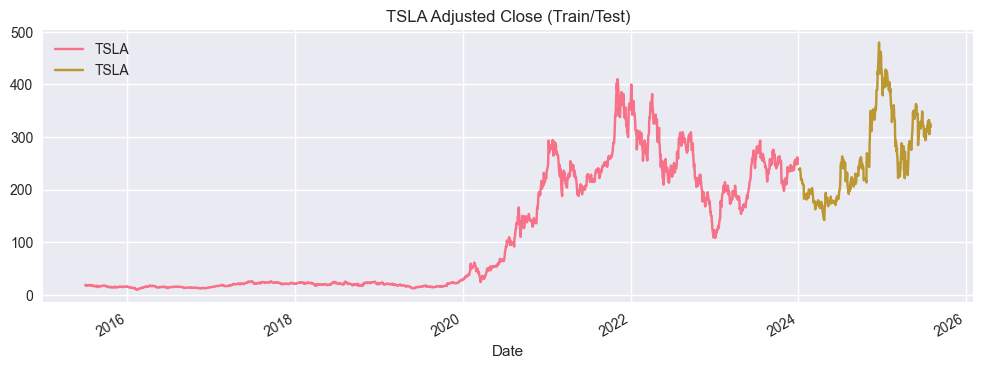

In [19]:
fig, ax = plt.subplots(figsize=(12,4))
train.plot(ax=ax, label='Train')
test.plot(ax=ax, label='Test')
ax.set_title('TSLA Adjusted Close (Train/Test)')
ax.legend();

##### 4) ARIMA order selection via grid search


In [20]:
best_order, metrics = arima_order_grid_search(train, p_values=range(0,4), d_values=range(0,2), q_values=range(0,4), criterion='aic')
best_order, metrics

((3, 1, 2), {'aic': 13613.087774634963, 'bic': 13647.096336889457})

##### 5) Train ARIMA and forecast over the test horizon


In [21]:
arima_model = ARIMAForecaster(order=best_order).fit(train)
arima_pred = arima_model.predict(steps=len(test))
arima_eval = arima_model.evaluate(np.asarray(test).flatten(), np.asarray(arima_pred).flatten())
arima_eval

INFO:models.forecasting_models:ARIMA model fitted successfully with order (3, 1, 2)


{'mse': 6089.870663694522,
 'mae': 63.13249643474631,
 'rmse': np.float64(78.03762338573954),
 'mape': np.float64(24.165670140440124)}

##### 6) Optional: SARIMA quick baseline


In [22]:
sarima = SARIMAForecaster(order=(1,1,1), seasonal_order=(1,1,1,12)).fit(train)
sarima_pred = sarima.predict(steps=len(test))
sarima_eval = sarima.evaluate(np.asarray(test).flatten(), np.asarray(sarima_pred).flatten())
sarima_eval

INFO:models.forecasting_models:SARIMA model fitted successfully with order (1, 1, 1) and seasonal order (1, 1, 1, 12)


{'mse': 4817.608225513919,
 'mae': 58.09333330119766,
 'rmse': np.float64(69.40899239661904),
 'mape': np.float64(23.941883459381707)}

##### 7) LSTM model


In [23]:
try:
    lstm = LSTMForecaster(units=64, dropout=0.2, epochs=10, batch_size=32, lookback=60)
    lstm.fit(train)
    lstm_pred = lstm.predict(steps=len(test))
    lstm_eval = lstm.evaluate(test, lstm_pred)
except Exception as e:
    lstm_pred, lstm_eval = None, {'mse': np.nan, 'mae': np.nan, 'rmse': np.nan, 'mape': np.nan}
lstm_eval

{'mse': nan, 'mae': nan, 'rmse': nan, 'mape': nan}

##### 8) Compare metrics


In [24]:
results = pd.DataFrame({
    'ARIMA': arima_eval,
    'SARIMA': sarima_eval,
    'LSTM': lstm_eval
}).T
results[['mae','rmse','mape']].sort_values('rmse')

,mae,rmse,mape
SARIMA,58.093333,69.408992,23.941883
ARIMA,63.132496,78.037623,24.165670
LSTM,NaN,NaN,NaN


##### 9) Plot forecasts vs actuals


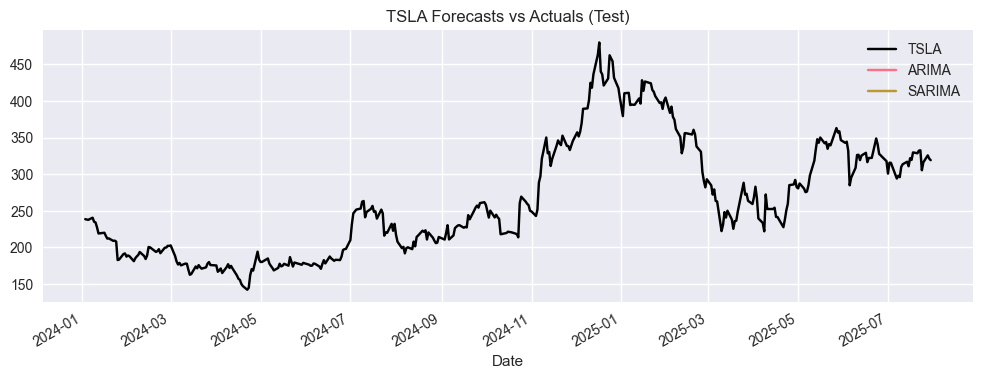

In [25]:
fig, ax = plt.subplots(figsize=(12,4))
test.plot(ax=ax, label='Actual', color='black')
pd.Series(arima_pred, index=test.index).plot(ax=ax, label='ARIMA')
pd.Series(sarima_pred, index=test.index).plot(ax=ax, label='SARIMA')
if lstm_pred is not None:
    pd.Series(lstm_pred, index=test.index).plot(ax=ax, label='LSTM')
ax.set_title('TSLA Forecasts vs Actuals (Test)')
ax.legend();

##### 10) Brief Discussion

- ARIMA/SARIMA offer interpretability and strong baselines on many financial series after proper differencing.
- LSTM can capture nonlinear patterns but requires careful tuning, more data, and is sensitive to scaling/lookback choices.
- Compare MAE/RMSE/MAPE above to decide which performed better on 2024–2025 test data.
